# Building a text classification model based on DistilBERT

## Prepare data as model input

Focus on data coming from the same accounts.

In [ ]:
from datasets import load_dataset

posts = load_dataset("csv", data_files = {
    "train" : "../data/text/acc_train.csv",
    "valid" : "../data/text/acc_valid.csv",
    "test" : "../data/text/acc_test.csv"
})

Tokenization, truncation, padding.

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

MODEL_NAME = "distilbert/distilbert-base-uncased"
MAX_LEN = 150

bert_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data_collator = DataCollatorWithPadding(tokenizer = bert_tokenizer, return_tensors = "tf")

def bert_preprocess(row):
    return bert_tokenizer(row["text"], truncation = True, max_length = MAX_LEN, padding = True)

posts_tok = posts.map(bert_preprocess)

## Prepare TensorFlow datasets

Fetch the pretrained model.

In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

Training, validation, test sets.

In [ ]:
BATCH_SIZE = 16

tf_train = model.prepare_tf_dataset(
    posts_tok["train"],
    shuffle = True,
    batch_size = BATCH_SIZE, 
    collate_fn = data_collator
)

tf_valid = model.prepare_tf_dataset(
    posts_tok["valid"],
    shuffle = True,
    batch_size = BATCH_SIZE, 
    collate_fn = data_collator
)

tf_test = model.prepare_tf_dataset(
    posts_tok["test"],
    shuffle = True,
    batch_size = BATCH_SIZE,
    collate_fn = data_collator
)

## Train and evaluate the model

Training hyperparameters

In [ ]:
from transformers import create_optimizer

N_EPOCHS = 5
BATCH_PER_EPOCH = len(posts_tok["train"]) // BATCH_SIZE
N_TRAIN_STEPS = int(BATCH_PER_EPOCH * N_EPOCHS)

optimizer, schedule = create_optimizer(init_lr = 2e-5, num_warmup_steps = 0, num_train_steps = N_TRAIN_STEPS)

Compile...

In [ ]:
model.compile(optimizer = optimizer, metrics = ["accuracy"])

... and fit.

In [ ]:
model.fit(
    x = tf_train, 
    validation_data = tf_valid,
    epochs = N_EPOCHS
)

The fitting is preferably conducted on Google Colab. Here is some results:
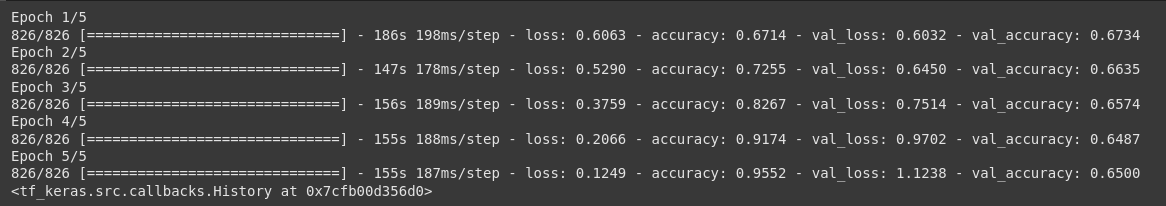

Evaluate

In [ ]:
model_eval = model.evaluate(tf_test)

Evaluation results:
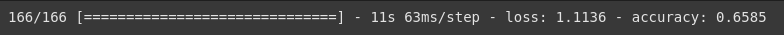

Save model:

In [ ]:
import os
if not os.path.exists("../models"):
    os.mkdir("../models")

model.save_pretrained("../models/mastodon_clf")